<a href="https://colab.research.google.com/github/Charry2014/sp500-ml-model/blob/main/sp500.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.youtube.com/watch?v=1O_BenficgE

In [ ]:
!pip install yfinance

import yfinance as yf

In [ ]:
sp500 = yf.Ticker("^GSPC")
sp500 = sp500.history(period="max")

In [ ]:
sp500.index

DatetimeIndex(['1927-12-30 00:00:00-05:00', '1928-01-03 00:00:00-05:00',
               '1928-01-04 00:00:00-05:00', '1928-01-05 00:00:00-05:00',
               '1928-01-06 00:00:00-05:00', '1928-01-09 00:00:00-05:00',
               '1928-01-10 00:00:00-05:00', '1928-01-11 00:00:00-05:00',
               '1928-01-12 00:00:00-05:00', '1928-01-13 00:00:00-05:00',
               ...
               '2024-01-23 00:00:00-05:00', '2024-01-24 00:00:00-05:00',
               '2024-01-25 00:00:00-05:00', '2024-01-26 00:00:00-05:00',
               '2024-01-29 00:00:00-05:00', '2024-01-30 00:00:00-05:00',
               '2024-01-31 00:00:00-05:00', '2024-02-01 00:00:00-05:00',
               '2024-02-02 00:00:00-05:00', '2024-02-05 00:00:00-05:00'],
              dtype='datetime64[ns, America/New_York]', name='Date', length=24139, freq=None)

<Axes: xlabel='Date'>

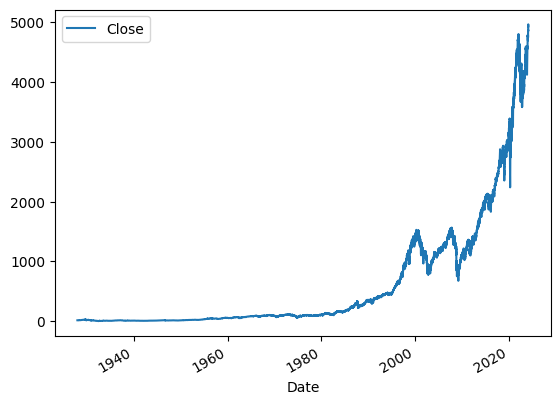

In [ ]:
sp500.plot.line(y="Close", use_index=True)

In [ ]:
del sp500["Dividends"]
del sp500["Stock Splits"]

Create a column with tomorrow's price

In [ ]:
sp500["Tomorrow"] = sp500["Close"].shift(-1)

Set a target - predict the direction of tomorrow

In [ ]:
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)

Trim off everything before 1990

In [ ]:
sp500 = sp500.loc["1990-01-01":].copy()

Train first model - default, random forest, bunch of individual decision trees with randomised results. Avoids overfitting, pick up nonlinear tendencies.

Can try with higher n estimators here, may work better.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train = sp500.iloc[:-100]
test = sp500.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

See how the model did

In [ ]:
from sklearn.metrics import precision_score
import pandas as pd

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.5

Result is as good as random choice.

Draw a picture of the results -

<Axes: xlabel='Date'>

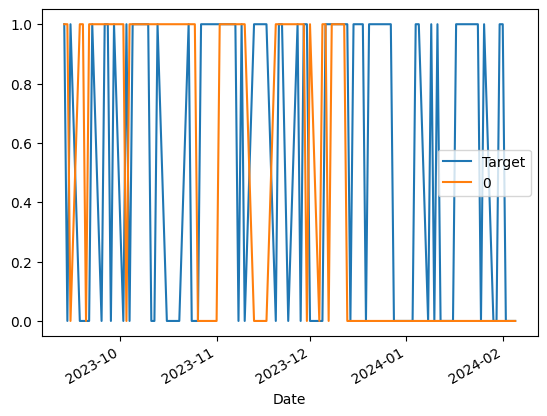

In [ ]:
combined = pd.concat([test["Target"], preds], axis=1)
combined.plot()

Backtesting system - make this more robust
Create a prediction function.

In [ ]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

Create the backtest function
Take 10 years of data (2500 work days) then go year by year working on predictions (250 work days in a year)

In [ ]:
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)

    return pd.concat(all_predictions)

Now we can run this.

In [ ]:
predictions = backtest(sp500, model, predictors)
predictions["Predictions"].value_counts()


0    3493
1    2596
Name: Predictions, dtype: int64

In [ ]:
precision_score(predictions["Target"], predictions["Predictions"])


0.5288906009244992

In [ ]:
predictions["Target"].value_counts() / predictions.shape[0]


1    0.534571
0    0.465429
Name: Target, dtype: float64

Set some horizons - day, week, 3 months, 1 year, 4 years, these become new predictors. Close ratio relative to rolling average. Rolling trend over the window. dropna drops lines with NaN elements.

In [ ]:
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()

    ratio_column = f"Close_Ratio_{horizon}"
    sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"]

    trend_column = f"Trend_{horizon}"
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]

    new_predictors+= [ratio_column, trend_column]

In [ ]:
sp500 = sp500.dropna(subset=sp500.columns[sp500.columns != "Tomorrow"])
sp500


,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
1993-12-14 00:00:00-05:00,465.730011,466.119995,462.459991,463.059998,275050000,461.839996,0,0.997157,1.0,0.996617,1.0,1.000283,32.0,1.028047,127.0,1.176082,512.0
1993-12-15 00:00:00-05:00,463.059998,463.690002,461.839996,461.839996,331770000,463.339996,1,0.998681,0.0,0.995899,1.0,0.997329,32.0,1.025151,126.0,1.172676,512.0
1993-12-16 00:00:00-05:00,461.859985,463.980011,461.859985,463.339996,284620000,466.380005,1,1.001621,1.0,0.999495,2.0,1.000311,32.0,1.028274,127.0,1.176163,513.0
1993-12-17 00:00:00-05:00,463.339996,466.380005,463.339996,466.380005,363750000,465.850006,0,1.003270,2.0,1.004991,3.0,1.006561,32.0,1.034781,128.0,1.183537,514.0
1993-12-20 00:00:00-05:00,466.380005,466.899994,465.529999,465.850006,255900000,465.299988,0,0.999431,1.0,1.003784,2.0,1.005120,32.0,1.033359,128.0,1.181856,513.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-30 00:00:00-05:00,4925.890137,4931.089844,4916.270020,4924.970215,3836130000,4845.649902,0,0.999700,1.0,1.004826,3.0,1.058476,40.0,1.131898,137.0,1.230836,528.0
2024-01-31 00:00:00-05:00,4899.189941,4906.750000,4845.149902,4845.649902,4696120000,4906.189941,1,0.991882,0.0,0.989567,2.0,1.039463,39.0,1.112925,136.0,1.210560,527.0
2024-02-01 00:00:00-05:00,4861.109863,4906.970215,4853.520020,4906.189941,4386090000,4958.609863,1,1.006208,1.0,1.001439,2.0,1.050393,39.0,1.126078,136.0,1.225211,527.0


Set the probability that the market goes up to 60%

In [ ]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >=.6] = 1
    preds[preds <.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined
predictions = backtest(sp500, model, new_predictors)
predictions["Predictions"].value_counts()


0.0    4257
1.0     832
Name: Predictions, dtype: int64

In [ ]:
precision_score(predictions["Target"], predictions["Predictions"])


0.5733173076923077

In [ ]:
predictions

,Target,Predictions
Date,,
2003-11-14 00:00:00-05:00,0,0.0
2003-11-17 00:00:00-05:00,0,1.0
2003-11-18 00:00:00-05:00,1,1.0
2003-11-19 00:00:00-05:00,0,0.0
2003-11-20 00:00:00-05:00,1,1.0
...,...,...
2024-01-30 00:00:00-05:00,0,0.0
2024-01-31 00:00:00-05:00,1,0.0
2024-02-01 00:00:00-05:00,1,0.0
